**Pyspark installation**

In [167]:
# from google.colab import drive
# drive.mount('/content/drive')

In [168]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark

In [169]:

# # !pip uninstall pyspark
# !pip install pyspark==3.0.0

In [170]:
# !pip install findspark

In [171]:
# import findspark
# findspark.init() 

**Import libraries**

In [172]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer

**Create Spark session**

In [173]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master('local')\
.appName('Housing Price Prediction')\
.getOrCreate()
sc = spark.sparkContext

**Import dataset**

In [174]:
# Read the datasets
df = spark.read.option('header', 'true').csv(os.path.join('/content/drive/MyDrive/new_project/', 'housing.csv'), inferSchema = True)

**Shape of the dataset**

In [175]:
print((df.count(), len(df.columns)))

(384980, 22)


In [176]:
df=df.limit(50000)

In [177]:
print((df.count(), len(df.columns)))

(50000, 22)


In [178]:
df.head(5)

[Row(id='7049044568', url='https://reno.craigslist.org/apa/d/reno-beautiful-3x2-newly-renovated/7049044568.html', region='reno / tahoe', region_url='https://reno.craigslist.org', price='1148', type='apartment', sqfeet='1078', beds='3', baths='2', cats_allowed='1', dogs_allowed='1', smoking_allowed='0', wheelchair_access='0', electric_vehicle_charge=0, comes_furnished='0', laundry_options='w/d in unit', parking_options='carport', image_url='https://images.craigslist.org/01616_daghmBUvTCI_600x450.jpg', description='Ridgeview by Vintage is where you will find all of your apartment living needs at a price you can afford!  Our spacious homes are located just off the freeway for easy access to shopping and entertainment, as well as a short drive from all the wonderful outdoor activities that the Truckee Meadows has to offer! Newly renovated homes and we have BRAND-NEW APPLIANCES! Some of the apartment features include; large windows for natural sunlight, central air conditioning and heating,

**Schema of the dataset**

In [179]:
df.printSchema()


root
 |-- id: string (nullable = true)
 |-- url: string (nullable = true)
 |-- region: string (nullable = true)
 |-- region_url: string (nullable = true)
 |-- price: string (nullable = true)
 |-- type: string (nullable = true)
 |-- sqfeet: string (nullable = true)
 |-- beds: string (nullable = true)
 |-- baths: string (nullable = true)
 |-- cats_allowed: string (nullable = true)
 |-- dogs_allowed: string (nullable = true)
 |-- smoking_allowed: string (nullable = true)
 |-- wheelchair_access: string (nullable = true)
 |-- electric_vehicle_charge: integer (nullable = true)
 |-- comes_furnished: string (nullable = true)
 |-- laundry_options: string (nullable = true)
 |-- parking_options: string (nullable = true)
 |-- image_url: string (nullable = true)
 |-- description: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- state: string (nullable = true)



In [180]:
df = df \
  .withColumn("price" ,
              df["price"]
              .cast(IntegerType()))   \
   .withColumn("sqfeet" ,
              df["sqfeet"]
              .cast(IntegerType()))   \
   .withColumn("beds" ,
              df["beds"]
              .cast(IntegerType())) \
   .withColumn("baths" ,
              df["baths"]
              .cast(IntegerType())) \
   .withColumn("dogs_allowed" ,
              df["dogs_allowed"]
              .cast(IntegerType())) \
     .withColumn("smoking_allowed" ,
              df["smoking_allowed"]
              .cast(IntegerType())) \
     .withColumn("wheelchair_access" ,
              df["wheelchair_access"]
              .cast(IntegerType()))  \
     .withColumn("comes_furnished" ,
              df["comes_furnished"]
              .cast(IntegerType()))  \
      .withColumn("cats_allowed" ,
              df["cats_allowed"]
              .cast(IntegerType())) 

In [181]:
df_p = df.toPandas()


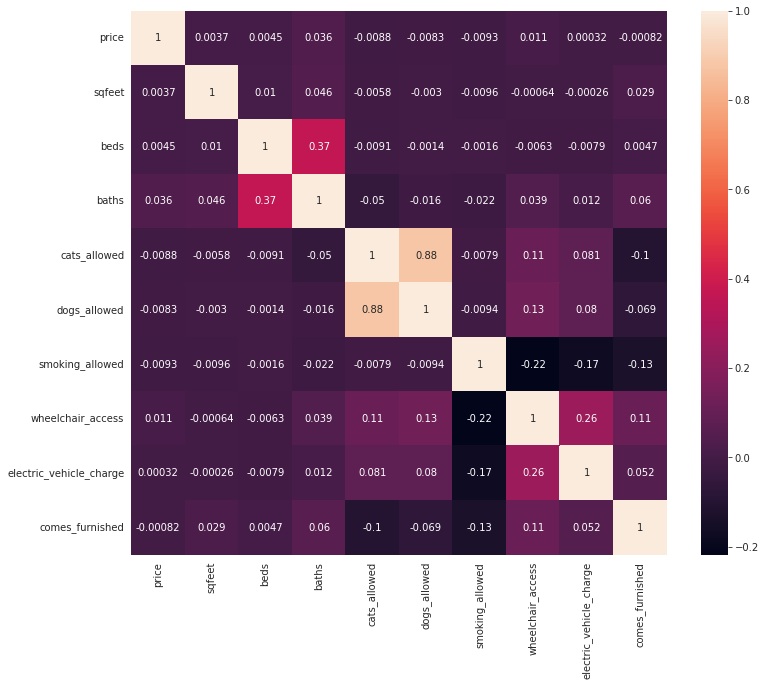

In [182]:
corrMatrix=df_p.corr()
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(corrMatrix,annot=True)

Text(0.5, 1.0, 'Which type of parking option has more price')

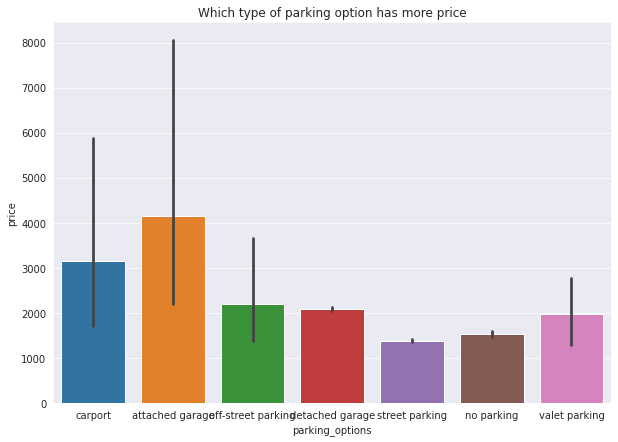

In [183]:
sns.barplot(x=df_p["parking_options"],y=df_p["price"])
fig = plt.gcf()
fig.set_size_inches(10,7)
plt.title('Which type of parking option has more price')

Text(0.5, 1.0, 'Which type of house has more sqfeet')

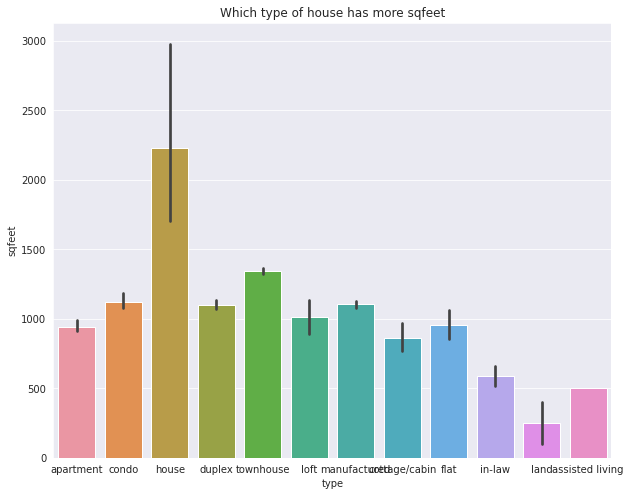

In [184]:
sns.barplot(x=df_p["type"],y=df_p["sqfeet"])
fig = plt.gcf()
fig.set_size_inches(10,8)
plt.title('Which type of house has more sqfeet')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


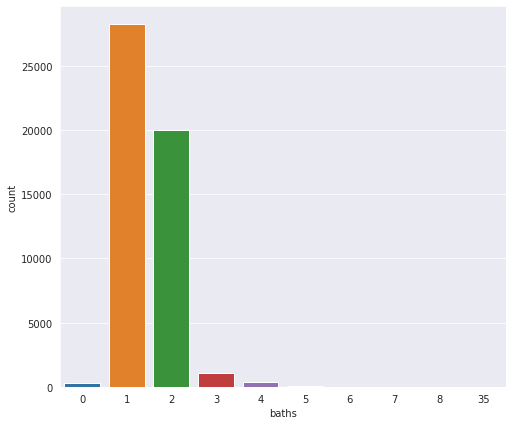

In [185]:
plt.figure(figsize=(8,7))

sns.countplot(df_p['baths'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


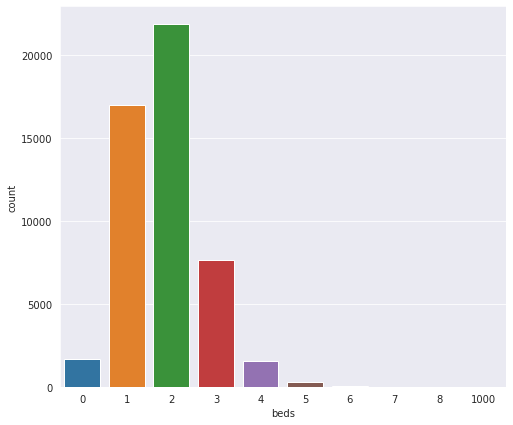

In [186]:
plt.figure(figsize=(8,7))

sns.countplot(df_p['beds'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


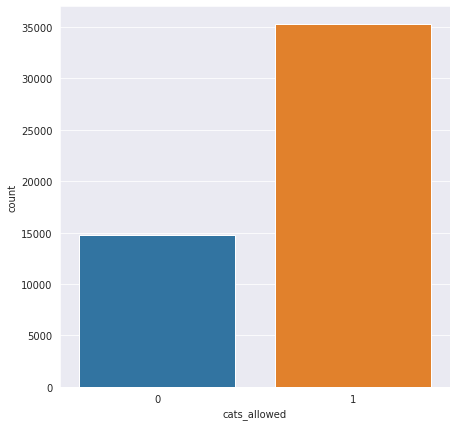

In [187]:
plt.figure(figsize=(7,7))

sns.countplot(df_p['cats_allowed'])


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


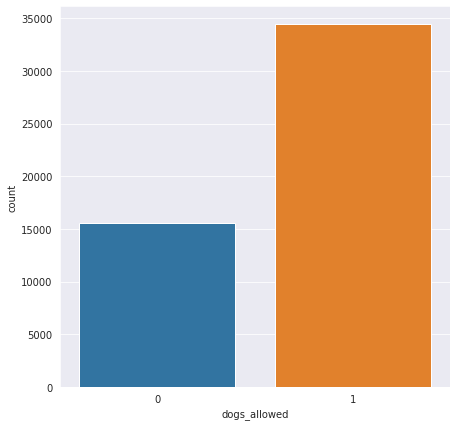

In [188]:
plt.figure(figsize=(7,7))

sns.countplot(df_p['dogs_allowed'])

**Statistics of the dataset**

In [189]:
#Checking data entries for each column
df.select([
 'beds',
 'baths',
 'cats_allowed',
 'dogs_allowed',
 'smoking_allowed',
 'wheelchair_access',
 'electric_vehicle_charge']).describe().show()

+-------+-----------------+------------------+------------------+------------------+-------------------+-------------------+-----------------------+
|summary|             beds|             baths|      cats_allowed|      dogs_allowed|    smoking_allowed|  wheelchair_access|electric_vehicle_charge|
+-------+-----------------+------------------+------------------+------------------+-------------------+-------------------+-----------------------+
|  count|            50000|             50000|             50000|             50000|              50000|              50000|                  50000|
|   mean|          1.85118|            1.4633|             0.705|           0.68808|            0.70926|            0.08478|                0.02734|
| stddev|4.552068434694357|0.6158089755873081|0.4560473216489598|0.4632819942584917|0.45410833144474855|0.27855682270960314|    0.16307377551625216|
|    min|                0|                 0|                 0|                 0|                  0|  

**Drop unwanted columns**

In [190]:
df=df.drop("id","url","region_url","image_url","description",'state')

**Handle missing values**

**Count the number of null values in each column using isnull() and display it.**

In [191]:
from pyspark.sql.functions import *
df.select([count(when(isnull(c), c))\
.alias(c) for c in df.columns]).show()

+------+-----+----+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+---------------+---------------+---+----+
|region|price|type|sqfeet|beds|baths|cats_allowed|dogs_allowed|smoking_allowed|wheelchair_access|electric_vehicle_charge|comes_furnished|laundry_options|parking_options|lat|long|
+------+-----+----+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+---------------+---------------+---+----+
|     0|    0|   0|     0|   0|    0|           0|           0|              0|                0|                      0|              0|          11487|          19039|193| 193|
+------+-----+----+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+---------------+---------------+---+----+



**Value counts of two columns**

In [192]:
df.select('laundry_options').show(5)

df.select('parking_options').show(5)

+---------------+
|laundry_options|
+---------------+
|    w/d in unit|
|    w/d hookups|
|    w/d in unit|
|    w/d in unit|
|laundry on site|
+---------------+
only showing top 5 rows

+---------------+
|parking_options|
+---------------+
|        carport|
|        carport|
|attached garage|
|        carport|
|           null|
+---------------+
only showing top 5 rows



**Fill missing values of two columns**

In [194]:
#replace null values in the column with the mode value
df= df.fillna({'laundry_options': 'w/d in unit','parking_options': 'carport'})
df.select([count(when(isnull(c), c))\
.alias(c) for c in df.columns]).show()



+------+-----+----+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+---------------+---------------+---+----+
|region|price|type|sqfeet|beds|baths|cats_allowed|dogs_allowed|smoking_allowed|wheelchair_access|electric_vehicle_charge|comes_furnished|laundry_options|parking_options|lat|long|
+------+-----+----+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+---------------+---------------+---+----+
|     0|    0|   0|     0|   0|    0|           0|           0|              0|                0|                      0|              0|              0|              0|193| 193|
+------+-----+----+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+---------------+---------------+---+----+



In [195]:
df=df.dropna()

In [196]:
from pyspark.sql.functions import *
df.select([count(when(isnull(c), c))\
.alias(c) for c in df.columns]).show()

+------+-----+----+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+---------------+---------------+---+----+
|region|price|type|sqfeet|beds|baths|cats_allowed|dogs_allowed|smoking_allowed|wheelchair_access|electric_vehicle_charge|comes_furnished|laundry_options|parking_options|lat|long|
+------+-----+----+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+---------------+---------------+---+----+
|     0|    0|   0|     0|   0|    0|           0|           0|              0|                0|                      0|              0|              0|              0|  0|   0|
+------+-----+----+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+---------------+---------------+---+----+



In [197]:
df.printSchema()

root
 |-- region: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- sqfeet: integer (nullable = true)
 |-- beds: integer (nullable = true)
 |-- baths: integer (nullable = true)
 |-- cats_allowed: integer (nullable = true)
 |-- dogs_allowed: integer (nullable = true)
 |-- smoking_allowed: integer (nullable = true)
 |-- wheelchair_access: integer (nullable = true)
 |-- electric_vehicle_charge: integer (nullable = true)
 |-- comes_furnished: integer (nullable = true)
 |-- laundry_options: string (nullable = false)
 |-- parking_options: string (nullable = false)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)



**Label encoding by using string indexer**

In [198]:
indexer = StringIndexer(inputCol="region", outputCol="region_index") 
df = indexer.fit(df).transform(df)
df = df.drop('region')
df.select('region_index').show(3)

+------------+
|region_index|
+------------+
|        19.0|
|        19.0|
|        19.0|
+------------+
only showing top 3 rows



In [199]:
indexer = StringIndexer(inputCol="type", outputCol="type_index") 
df = indexer.fit(df).transform(df)
df = df.drop('type')
df.select('type_index').show(3)

+----------+
|type_index|
+----------+
|       0.0|
|       3.0|
|       0.0|
+----------+
only showing top 3 rows



In [200]:
indexer = StringIndexer(inputCol="laundry_options", outputCol="laundry_options_index") 
df = indexer.fit(df).transform(df)
df = df.drop('laundry_options')
df.select('laundry_options_index').show(3)

+---------------------+
|laundry_options_index|
+---------------------+
|                  0.0|
|                  2.0|
|                  0.0|
+---------------------+
only showing top 3 rows



In [201]:
indexer = StringIndexer(inputCol="parking_options", outputCol="parking_options_index") 
df = indexer.fit(df).transform(df)
df = df.drop('parking_options')
df.select('parking_options_index').show(3)

+---------------------+
|parking_options_index|
+---------------------+
|                  0.0|
|                  0.0|
|                  2.0|
+---------------------+
only showing top 3 rows



In [202]:
indexer = StringIndexer(inputCol="lat", outputCol="lat_index") 
df = indexer.fit(df).transform(df)
df = df.drop('lat')
df.select('lat_index').show(3)

+---------+
|lat_index|
+---------+
|    387.0|
|   7907.0|
|    137.0|
+---------+
only showing top 3 rows



In [203]:
indexer = StringIndexer(inputCol="long", outputCol="long_index") 
df = indexer.fit(df).transform(df)
df = df.drop('long')
df.select('long_index').show(3)

+----------+
|long_index|
+----------+
|     443.0|
|    4548.0|
|      95.0|
+----------+
only showing top 3 rows



**Dataframe after using string indexer**

In [204]:
df.show()

+-----+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+------------+----------+---------------------+---------------------+---------+----------+
|price|sqfeet|beds|baths|cats_allowed|dogs_allowed|smoking_allowed|wheelchair_access|electric_vehicle_charge|comes_furnished|region_index|type_index|laundry_options_index|parking_options_index|lat_index|long_index|
+-----+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+------------+----------+---------------------+---------------------+---------+----------+
| 1148|  1078|   3|    2|           1|           1|              0|                0|                      0|              0|        19.0|       0.0|                  0.0|                  0.0|    387.0|     443.0|
| 1200|  1001|   2|    2|           0|           0|              0|                0|                      0|              0|        19.0|  

**Print schema after using string indexer**

In [205]:
df.printSchema()

root
 |-- price: integer (nullable = true)
 |-- sqfeet: integer (nullable = true)
 |-- beds: integer (nullable = true)
 |-- baths: integer (nullable = true)
 |-- cats_allowed: integer (nullable = true)
 |-- dogs_allowed: integer (nullable = true)
 |-- smoking_allowed: integer (nullable = true)
 |-- wheelchair_access: integer (nullable = true)
 |-- electric_vehicle_charge: integer (nullable = true)
 |-- comes_furnished: integer (nullable = true)
 |-- region_index: double (nullable = false)
 |-- type_index: double (nullable = false)
 |-- laundry_options_index: double (nullable = false)
 |-- parking_options_index: double (nullable = false)
 |-- lat_index: double (nullable = false)
 |-- long_index: double (nullable = false)



**Use Vector Assembler**

In [208]:

from pyspark.ml.feature import VectorAssembler

# convert to vector column first
assembler = VectorAssembler(inputCols=df.columns, outputCol="features")
df_vector = assembler.transform(df).select("features")

In [209]:
df.columns

['price',
 'sqfeet',
 'beds',
 'baths',
 'cats_allowed',
 'dogs_allowed',
 'smoking_allowed',
 'wheelchair_access',
 'electric_vehicle_charge',
 'comes_furnished',
 'region_index',
 'type_index',
 'laundry_options_index',
 'parking_options_index',
 'lat_index',
 'long_index']

**Select important features for Modeling**

In [210]:

df_model = df.select(['price','sqfeet','beds','baths','region_index','type_index','laundry_options_index','parking_options_index','lat_index','long_index'])
df_model.show(3)

+-----+------+----+-----+------------+----------+---------------------+---------------------+---------+----------+
|price|sqfeet|beds|baths|region_index|type_index|laundry_options_index|parking_options_index|lat_index|long_index|
+-----+------+----+-----+------------+----------+---------------------+---------------------+---------+----------+
| 1148|  1078|   3|    2|        19.0|       0.0|                  0.0|                  0.0|    387.0|     443.0|
| 1200|  1001|   2|    2|        19.0|       3.0|                  2.0|                  0.0|   7907.0|    4548.0|
| 1813|  1683|   2|    2|        19.0|       0.0|                  0.0|                  2.0|    137.0|      95.0|
+-----+------+----+-----+------------+----------+---------------------+---------------------+---------+----------+
only showing top 3 rows



In [211]:
#Assembling features
feature_assembly = VectorAssembler(inputCols = ['price','sqfeet','beds','baths','region_index','type_index','laundry_options_index','parking_options_index','lat_index','long_index'], outputCol = 'features')
output = feature_assembly.transform(df)
output.show(3)

+-----+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+------------+----------+---------------------+---------------------+---------+----------+--------------------+
|price|sqfeet|beds|baths|cats_allowed|dogs_allowed|smoking_allowed|wheelchair_access|electric_vehicle_charge|comes_furnished|region_index|type_index|laundry_options_index|parking_options_index|lat_index|long_index|            features|
+-----+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+------------+----------+---------------------+---------------------+---------+----------+--------------------+
| 1148|  1078|   3|    2|           1|           1|              0|                0|                      0|              0|        19.0|       0.0|                  0.0|                  0.0|    387.0|     443.0|[1148.0,1078.0,3....|
| 1200|  1001|   2|    2|           0|           0|     

**Data Normalization**

In [212]:
#Normalizing the features
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(output)

# Normalize each feature to have unit standard deviation.
scaledOutput = scalerModel.transform(output)
scaledOutput.show(3)

+-----+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+------------+----------+---------------------+---------------------+---------+----------+--------------------+--------------------+
|price|sqfeet|beds|baths|cats_allowed|dogs_allowed|smoking_allowed|wheelchair_access|electric_vehicle_charge|comes_furnished|region_index|type_index|laundry_options_index|parking_options_index|lat_index|long_index|            features|      scaledFeatures|
+-----+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+------------+----------+---------------------+---------------------+---------+----------+--------------------+--------------------+
| 1148|  1078|   3|    2|           1|           1|              0|                0|                      0|              0|        19.0|       0.0|                  0.0|                  0.0|    387.0|     443.0|[1148.0,1078.0,

In [213]:
#Selecting input and output column from output
df_model_final = scaledOutput.select(['price', 'scaledFeatures'])
df_model_final.show(3)

+-----+--------------------+
|price|      scaledFeatures|
+-----+--------------------+
| 1148|[0.01447865168250...|
| 1200|[0.01513447911063...|
| 1813|[0.02286567552297...|
+-----+--------------------+
only showing top 3 rows



**Linear Regression**

In [214]:
from pyspark.ml.regression import LinearRegression 

#test train split
df_train, df_test = df_model_final.randomSplit([0.75, 0.25])
regressor = LinearRegression(featuresCol = 'scaledFeatures', labelCol = 'price')
regressor = regressor.fit(df_train)

**Prediction on test data**

In [215]:
#make predictions on the test set
predictions= regressor.transform(df_test)
# show the predicted values and the actual values
predictions.select('prediction' ,'price').show(20)

+--------------------+-----+
|          prediction|price|
+--------------------+-----+
|1.353197097447880...|    0|
|1.735943021449828...|    0|
|1.445566193030284...|    0|
|1.445566193030284...|    0|
|1.445566193030284...|    0|
|-2.40118420982515...|    0|
|-2.40118420982515...|    0|
|-2.76162075258981...|    0|
|-2.76162075258981...|    0|
|  1.0000000000710403|    1|
|  0.9999999999725656|    1|
|  0.9999999999725656|    1|
|  0.9999999999725656|    1|
|  0.9999999999725656|    1|
|  0.9999999998983568|    1|
|  0.9999999998622879|    1|
|   4.999999999711918|    5|
|   40.00000000030009|   40|
|   39.99999999999005|   40|
|   70.00000000019907|   70|
+--------------------+-----+
only showing top 20 rows



In [216]:
predictions.show()

+-----+--------------------+--------------------+
|price|      scaledFeatures|          prediction|
+-----+--------------------+--------------------+
|    0|[0.0,0.0632539075...|1.353197097447880...|
|    0|[0.0,0.0759046891...|1.735943021449828...|
|    0|[0.0,0.0965254629...|1.445566193030284...|
|    0|[0.0,0.0965254629...|1.445566193030284...|
|    0|[0.0,0.0965254629...|1.445566193030284...|
|    0|[0.0,0.1401706592...|-2.40118420982515...|
|    0|[0.0,0.1401706592...|-2.40118420982515...|
|    0|[0.0,0.1631950815...|-2.76162075258981...|
|    0|[0.0,0.1631950815...|-2.76162075258981...|
|    1|[1.26120659255264...|  1.0000000000710403|
|    1|[1.26120659255264...|  0.9999999999725656|
|    1|[1.26120659255264...|  0.9999999999725656|
|    1|[1.26120659255264...|  0.9999999999725656|
|    1|[1.26120659255264...|  0.9999999999725656|
|    1|[1.26120659255264...|  0.9999999998983568|
|    1|[1.26120659255264...|  0.9999999998622879|
|    5|[6.30603296276320...|   4.999999999711918|


**Evaluation metrics**

**R2 Score**

In [217]:
#R2 score on test set
r2_test= regressor.evaluate(df_test).r2
print('R2 score on test set: ', r2_test)

R2 score on test set:  1.0


**RMSE**

In [218]:
#RMSE on test set
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='price',metricName='rmse')
rmse_test = evaluator.evaluate(predictions)
print('RMSE on test set: ', rmse_test)

RMSE on test set:  4.71839693892618e-10


**Unsupervised Learning**

**Kmeans Clustering**

In [219]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='scaledFeatures', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')

**Find best value of K**

In [220]:
for i in range(2,15):
    
    KMeans_algo=KMeans(featuresCol='scaledFeatures', k=i)
    
    KMeans_fit=KMeans_algo.fit(df_model_final)
    
    output=KMeans_fit.transform(df_model_final)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)

Silhouette Score: 0.6030766683071473
Silhouette Score: 0.28176408073431936
Silhouette Score: 0.3134023823985729
Silhouette Score: 0.3172165661460817
Silhouette Score: 0.2715352375041178
Silhouette Score: 0.34069899108436474
Silhouette Score: 0.22486263022292396
Silhouette Score: 0.3090830042108829
Silhouette Score: 0.23700105647556224
Silhouette Score: 0.27176913098423644
Silhouette Score: 0.3159955519646402
Silhouette Score: 0.3475289207623991
Silhouette Score: 0.3626791288718943


**Visualizing the silhouette scores in a plot**

Text(0, 0.5, 'value')

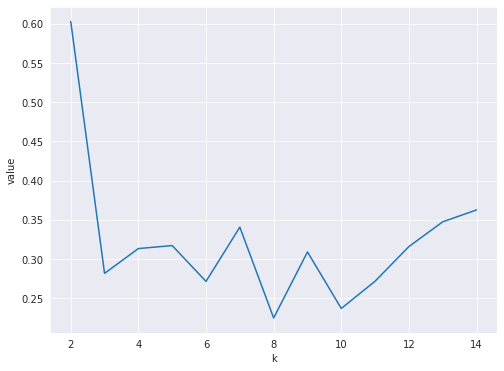

In [221]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,15),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('value')

**Training Model with k=8**

In [222]:
k = 8
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("scaledFeatures")
model = kmeans.fit(df_model_final)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[0.01852686 0.11179691 0.34463112 2.11355345 0.86110379 0.02753524
 0.23602129 0.21746248 0.23450629 0.2598433 ]
[0.02393833 0.1326564  0.39681332 2.5197235  1.16114806 0.17639122
 0.20480101 2.54817587 0.42692017 0.44393896]
[0.19624657 0.13657614 0.46855858 2.51285318 1.69954756 4.12621222
 1.076629   0.95030195 1.18175233 1.11696129]
[8.13478252e-02 1.28182399e+02 7.30941134e-01 3.79411127e+00
 2.86670556e+00 6.60344494e-01 3.03558807e+00 1.46027940e+00
 1.93964882e+00 4.84308133e-01]
[0.01679227 0.11724292 0.38053422 2.12583183 1.37956075 0.15937775
 2.46737748 0.69964147 0.34360989 0.41084639]
[0.02714696 0.15801668 0.50040847 2.56200802 1.80277048 0.65057397
 0.85009612 1.09987338 2.87116411 2.68239231]
[1.89180989e-02 1.26507815e-02 2.19282340e+02 5.69116691e+01
 3.17542770e+00 9.90516741e+00 1.01186269e+00 8.76167640e-01
 2.04079902e+00 4.24372418e+00]
[0.02113797 0.14325439 0.48310514 2.98950755 2.50159658 0.16920162
 0.41975588 0.36658518 0.35164482 0.464257

**Final clusters**

In [223]:
transformed = model.transform(df_model_final)
transformed.select('price', 'prediction')
rows = transformed.collect()
print(rows[:3])

[Row(price=1148, scaledFeatures=DenseVector([0.0145, 0.1364, 0.6578, 3.2521, 2.5139, 0.0, 0.0, 0.0, 0.1812, 0.3052]), prediction=7), Row(price=1200, scaledFeatures=DenseVector([0.0151, 0.1266, 0.4386, 3.2521, 2.5139, 2.9716, 2.0237, 0.0, 3.7028, 3.1332]), prediction=5), Row(price=1813, scaledFeatures=DenseVector([0.0229, 0.2129, 0.4386, 3.2521, 2.5139, 0.0, 0.0, 1.7523, 0.0642, 0.0654]), prediction=7)]
